In [1]:
#load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import numpy as np
import os
from scipy.stats.stats import pearsonr
import itertools
from scipy import stats
import seaborn as sns

matplotlib.rcParams.update({'font.size': 12})

## Original vs. Optimized Antibody Order


round changes, old (K154) to new (K175)

same- CK19, ER, HER2

CD4 R3 > R7 ***

CD8 R1 > R7 ***

CD20 R6 > R8 

CD31 R4 > R10 ***

CD44 R4 < R3 

CD45 R2 > R6 ***

CD68 R2 > R6 ***

CK14 R5 < R1 ***

CK5 R2 > R4 

CK7 R5 > R6

CK8 R9 < R8

CK17 R7 > R9

ColI R8 > R9

ColIV R10 > R8

Ecad R3 > R2

EGFR R7 < R4 ***

FoxP3 R10 < R5 ***

GRNZB R7 > R10 ***

H3K4 R10 < R9

H3K27 R8 > R10

Ki67 R5 < R1 ***

LamAC R11 < R4 ***

LamB1 R11 < R10

Lam B2 R11 > R12

PCNA R1 > R2

PD1 R1 > R6 ***

PDPN R8 < R5 ***

PgR R5 > R7

pAKT R7 < R3 ***

pERK R6 < R5

pHH3 R6 < R5

pRB R9 < R4 ***

pS6 R6 > R10 ***

Vim R4 > R7 ***


*** more than 2 rounds difference


In [2]:
#set location of files
codedir = '/home/groups/graylab_share/OMERO.rdsStore/engje/Data/cycIF_ValidationStudies'

In [3]:
#load positive (thresholded using AF subtracted for K154/ non AF sub for K175)
df_pos = pd.read_csv(f'{codedir}/Data/Her2B-K154-6S_DAPI11_Nuclei1000_ManualPositive.txt',index_col=0,sep='\t')
df_pos['scene'] = ['scene'+ item.split('_')[1].split('scene0')[1] for item in df_pos.index]

df_pos_new = pd.read_csv(f'{codedir}/Data/Her2B-K175_DAPI12_Nuclei1000_ManualPositive.csv',index_col=0)


#read in full features (all locations, cells)
df_mi = pd.read_csv(f'{codedir}/Data/features_Her2B-K154-6S_MeanIntensity.tsv',index_col=0,sep='\t')
df_mi['scene'] = ['scene'+ item.split('_')[0].split('scene0')[1] for item in df_mi.index]

df_mi_new = pd.read_csv(f'{codedir}/Data/features_HER2B-K175_MeanIntensity.tsv',index_col=0,sep='\t')
df_mi_new['scene'] = [item.split('_')[0] for item in df_mi_new.index]

In [ ]:
df_mi_new = df_mi_new[df_mi_new.scene.isin(['scene02', 'scene04', 'scene05', 'scene06', 'scene08', 'scene09'])]
df_pos_new = df_pos_new[df_pos_new.scene.isin(['scene02', 'scene04', 'scene05', 'scene06', 'scene08', 'scene09'])]

In [ ]:
print(len(df_mi))
print(len(df_pos))
print(len(df_mi_new))
print(len(df_pos_new))

# K154 and K175 analysis plan

1 - use "good" markers (based on visual estimation of staining; low background markers) to define 5 tissue compartments.

2 - calculate the signal for each marker (expression in correct compartment) e.g. for CD45, T-cell cytoplasm

3 - calculate the background for each marker (expression in incorrect compartment) - e.g. for CD45, tumor nuclei

4 - Visualize intensity distribution of early and late signal and background

In [7]:
#compartments

#define tumor and immune cell types
ls_tumor = ['CK19_Ring','CK5_Ring','Ecad_Ring','CK14_Ring'] # #'CK7_Ring'= poor quench, CK17_Ring = too many pos comapred to CK5 and CK14
ls_exclude = ['CD31_Ring','CD68_Ring','CD4_Ring'] # cd45 not good?
df_pos['all-tumor'] = df_pos.loc[:,ls_tumor].sum(axis=1)>=1 
df_pos['not-tumor'] = df_pos.loc[:,ls_exclude].sum(axis=1)>=1
df_pos['not-tumor-not-Tcell'] = df_pos.loc[:,['CD31_Ring','CD68_Ring',]].sum(axis=1)>=1
df_pos['tumor'] = (df_pos.loc[:,'all-tumor'].astype(int) -  df_pos.loc[:,'not-tumor'].astype(int))==1
df_pos['Endothelial'] = df_pos.loc[:,'CD31_Ring']
df_pos['Macrophage'] = (df_pos.loc[:,'CD68_Ring'].astype(int) - df_pos.loc[:,'CD31_Ring'].astype(int)) == 1
#df_pos['Tcell'] = (df_pos.loc[:,'CD4_Ring'].astype(int) -  df_pos.loc[:,'not-tumor-not-Tcell'].astype(int))==1
df_pos['CD4Tcell'] = (df_pos.loc[:,'CD4_Ring'].astype(int) -  df_pos.loc[:,'not-tumor-not-Tcell'].astype(int))==1
df_pos['CD8Tcell'] = (df_pos.loc[:,'CD8_Ring'].astype(int) + df_pos.loc[:,'CD45_Ring'].astype(int) -  df_pos.loc[:,'not-tumor-not-Tcell'].astype(int))==2
df_pos['T-cell'] = (df_pos.loc[:,'CD8Tcell'].astype(int) + df_pos.loc[:,'CD4Tcell'].astype(int)) >= 1
df_pos['Basal'] = (df_pos.loc[:,'tumor'].astype(int) - df_pos.loc[:,'CK19_Ring'].astype(int)) == 1

df_pos['Stromal'] = (df_pos.loc[:,['tumor']].sum(axis=1) ==0)#,'Tcell','Mac','Endothelial'
df_pos = df_pos.drop(['all-tumor','not-tumor','not-tumor-not-Tcell'],axis=1)

#new order
df_pos_new['all-tumor'] = df_pos_new.loc[:,ls_tumor].sum(axis=1)>=1 
df_pos_new['not-tumor'] = df_pos_new.loc[:,ls_exclude].sum(axis=1)>=1
df_pos_new['not-tumor-not-Tcell'] = df_pos_new.loc[:,['CD31_Ring','CD68_Ring',]].sum(axis=1)>=1
df_pos_new['tumor'] = (df_pos_new.loc[:,'all-tumor'].astype(int) -  df_pos_new.loc[:,'not-tumor'].astype(int))==1
df_pos_new['Endothelial'] = df_pos_new.loc[:,'CD31_Ring']
df_pos_new['Macrophage'] = (df_pos_new.loc[:,'CD68_Ring'].astype(int) - df_pos_new.loc[:,'CD31_Ring'].astype(int)) == 1
df_pos_new['CD4Tcell'] = (df_pos_new.loc[:,'CD4_Ring'].astype(int) -  df_pos_new.loc[:,'not-tumor-not-Tcell'].astype(int))==1
df_pos_new['CD8Tcell'] = (df_pos_new.loc[:,'CD8_Ring'].astype(int) + df_pos_new.loc[:,'CD45_Ring'].astype(int) -  df_pos_new.loc[:,'not-tumor-not-Tcell'].astype(int))==2
df_pos_new['T-cell'] = (df_pos_new.loc[:,'CD8Tcell'].astype(int) + df_pos_new.loc[:,'CD4Tcell'].astype(int)) >= 1
df_pos_new['Basal'] = (df_pos_new.loc[:,'tumor'].astype(int) - df_pos_new.loc[:,'CK19_Ring'].astype(int)) == 1

df_pos_new['Stromal'] = (df_pos_new.loc[:,['tumor']].sum(axis=1) ==0)
df_pos_new = df_pos_new.drop(['all-tumor','not-tumor','not-tumor-not-Tcell'],axis=1)


In [8]:
#five compartments
df_pos.loc[:,['tumor','CD4Tcell','CD8Tcell','Macrophage','Endothelial','Stromal','Basal']].sum()

tumor          31905
CD4Tcell        9166
CD8Tcell        2170
Macrophage      5630
Endothelial     4276
Stromal        34602
Basal           3204
dtype: int64

In [9]:
#five compartments
df_pos_new.loc[:,['tumor','T-cell','Macrophage','Endothelial','Stromal','Basal']].sum()

tumor          20978
T-cell          5257
Macrophage      3771
Endothelial     3117
Stromal        43906
Basal          11829
dtype: int64

In [10]:
#Annotate the compartment of signal and background for each marker
#dd key is forground, d key is cell type, d item is bg
dd_exclusive = {'CD4Tcell':{ 'FoxP3_Nuclei':'tumor',
    'GRNZB_Nuclei':'tumor',
    'PD1_Ring':'tumor',
    'CD20_Ring':'tumor',
    'CD45_Ring':'tumor',
    'CD4_Ring':'tumor'},
 'CD8Tcell': {'CD8_Ring':'tumor',},
'tumor':{'CK8_Ring':'Stromal',
    'Ecad_Ring':'Stromal',
    'PgR_Nuclei':'Stromal',
        'LamAC_Nuclei':'Stromal',
        'pRB_Nuclei':'Stromal',
        'Ki67_Nuclei':'Stromal'},
'Basal':{    'CK5_Ring':'Stromal',
    'CK17_Ring':'Stromal',
    'CK14_Ring':'Stromal',
    'aSMA_Ring':'T-cell',
    'ColIV_Ring':'tumor',},
'Endothelial': {'CD31_Ring':'tumor',},
'Mac':{'CD68_Ring':'tumor',},
'Stromal':{
        'PDPN_Ring':'tumor',
        'CD44_Ring':'Endothelial',
        'Vim_Ring':'tumor',}
               }

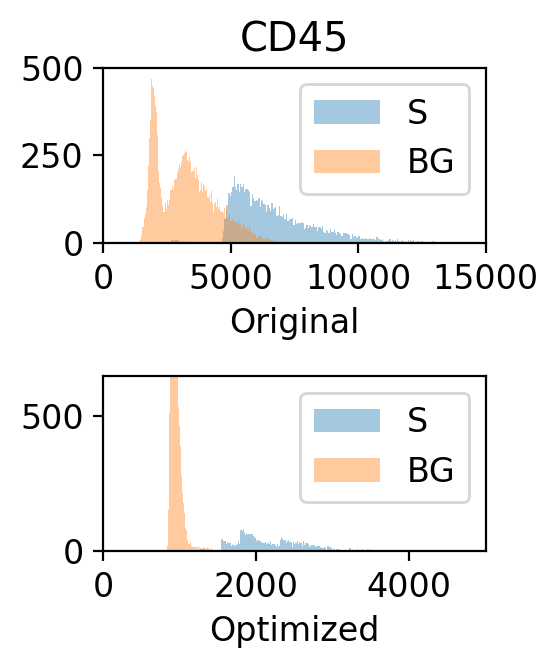

In [19]:
#produce single cell histograms

for s_fg, d_exclusive in dd_exclusive.items():
    for s_marker, s_bg in d_exclusive.items():  
        s_marker = 'CD45_Ring'
        boolx = True
        if s_marker=='CD45_Ring':
            boolx=False
        fig, ax = plt.subplots(2,1, figsize=(3,3.5),sharex=boolx,sharey=boolx,dpi=200)
        ax=ax.ravel()
        fg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_marker]].index]
        #old
        i_bins = 500
        bg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        se_fg = df_mi.loc[fg_index,s_marker]
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        sns.distplot(se_fg,bins=i_bins,ax=ax[0],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=i_bins,ax=ax[0],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[0].legend()
        ax[0].set_title(f'{s_marker.split("_")[0]}')
        ax[0].set_xlabel('Original')
        #new
        fg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_marker]].index]
        bg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_bg]].index]
        if s_marker == 'CD45_Ring':
            i_bins=300
        se_fg = df_mi_new.loc[fg_index,f'{s_marker.split("_")[0]}_{s_marker.split("_")[1]}']
        se_bg = df_mi_new.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1].replace('Ring','Nucleus').replace('Nuclei','Ring').replace('Nucleus','Nuclei')}"]
        sns.distplot(se_fg,bins=i_bins,ax=ax[1],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=i_bins,ax=ax[1],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[1].legend()
        ax[1].set_xlabel('Optimized')
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/Her2B-K175/K154vs175_histogram_{s_marker.split("_")[0]}.png')
        if s_marker == 'CD45_Ring':
            ax[1].set_xlim(0,5000)
            ax[1].set_ylim(0,650)
            ax[0].set_xlim(0,15000)
            ax[0].set_ylim(0,500)
            fig.savefig(f'{codedir}/Figures/Her2B-K175/K154vs175_Zoomedhistogram_{s_marker.split("_")[0]}.png')
        else:
            plt.close(fig)
        break
    break
                    

    

In [ ]:
#PD1
for s_fg, d_exclusive in dd_exclusive.items():
    for s_marker, s_bg in d_exclusive.items():     
        s_marker='PD1_Ring'
        fig, ax = plt.subplots(2,1, figsize=(3,3.5),sharex=True,sharey=True,dpi=200)
        ax=ax.ravel()
        fg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_marker]].index]
        #old
        bg_index = [item.split('Her2B-K154-6S_')[1] for item in  df_pos[df_pos.loc[:,s_bg]].index]
        i_bins = 500
        se_fg = df_mi.loc[fg_index,s_marker]
        se_bg = df_mi.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1]}"]
        sns.distplot(se_fg,bins=i_bins,ax=ax[0],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=i_bins,ax=ax[0],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[0].legend()
        ax[0].set_title(f'{s_marker.split("_")[0]}')
        ax[0].set_xlabel('Original')
        #new
        fg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_marker]].index]
        bg_index = [item.split('HER2B-K175_')[1] for item in  df_pos_new[df_pos_new.loc[:,s_bg]].index]
        #fg_index = set(marker_index) - set(bg_index)
        se_fg = df_mi_new.loc[fg_index,f'{s_marker.split("_")[0]}_{s_marker.split("_")[1]}']
        se_bg = df_mi_new.loc[bg_index,f"{s_marker.split('_')[0]}_{s_marker.split('_')[1]}"]
        sns.distplot(se_fg,bins=i_bins,ax=ax[1],kde=False,label='S',hist_kws=dict(alpha=0.4))                       
        sns.distplot(se_bg,bins=i_bins,ax=ax[1],kde=False,label='BG',hist_kws=dict(alpha=0.4))
        ax[1].legend()
        ax[1].set_xlabel('Optimized')
        ax[1].set_xlim(0,10000)
        ax[1].set_ylim(0,500)
        ax[0].set_xlim(0,10000)
        ax[0].set_ylim(0,500)
        plt.tight_layout()
        fig.savefig(f'{codedir}/Figures/Her2B-K175/K154vs175_histogram_{s_marker.split("_")[0]}_Ring.png')
        break
    break